In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from portfolio import Portfolio
%matplotlib inline 

## read in data
ret_df_raw= pd.read_excel( io= 'Data/cipc data.xlsx', sheetname= 'Data_Input', index_col=0)

ret_df= ret_df_raw[['US_RE', 
                   'US_PE',
                   'US_CORP',
                   'SP500',
                   'Rusell2000',
                   'EAFE',
                   'EM']]
                   #'USGOVT10Y']]
ret_df_cov= ret_df.cov()

UniverseProperty= {}

from sklearn.covariance import LedoitWolf
LW= LedoitWolf( ).fit(ret_df)
LW_alpha= LW.shrinkage_

LW_cov= pd.DataFrame(LW.covariance_)*4
LW_cov.index= ret_df_cov.index
LW_cov.columns= ret_df_cov.columns
LW_vol= np.sqrt(np.diag(LW_cov))
LW_corr= pd.DataFrame( np.dot( np.dot( np.diag(1/ LW_vol), LW_cov), np.diag(1/LW_vol)) , 
                      index= LW_cov.index, columns= LW_cov.columns)
CMA_passive_geo= np.array( [7, 8.8, 2.75, 7.21, 8.06, 7.07, 8.03 ])/100
CMA_active_geo= CMA_passive_geo+ np.array( [0,0, 0.5, 1,1,1,1])/100
CMA_passive_arith= CMA_passive_geo+ 0.5* LW_vol**2
LW_cov_active= LW_cov+ np.diag([0, 0, 4, 9,9,9,9])/10000
LW_vol_active= np.sqrt(np.diag(LW_cov_active))
CMA_active_arith= CMA_active_geo+ 0.5* LW_vol_active**2

# the asset universe properties
UniverseProperty['asset_name']= LW_cov.index.tolist()
UniverseProperty['asset_count']= LW_cov.shape[0]
UniverseProperty['LW_cov']= LW_cov
UniverseProperty['LW_vol']= LW_vol
UniverseProperty['LW_corr']= LW_corr
UniverseProperty['CMA_active_geo']= CMA_active_geo
UniverseProperty['CMA_active_arith']= CMA_active_arith
UniverseProperty['LW_cov_active']= LW_cov_active
UniverseProperty['LW_vol_active']= LW_vol_active


# Portfolios

portfolios= {}
portfolios['EqualWeights']= Portfolio(asset_ret= UniverseProperty['CMA_active_geo'], 
                                      asset_cov= UniverseProperty['LW_cov_active'], 
                                      weight= [1/UniverseProperty['asset_count']]* UniverseProperty['asset_count'])

tmp= np.array([0.14,0.29,0.05,0.24,0.03,0.21,0.05])
tmp= tmp/ np.sum(tmp)
portfolios['Peer']= Portfolio( asset_ret= UniverseProperty['CMA_active_geo'],
                             asset_cov= UniverseProperty['LW_cov_active'], 
                             weight= tmp)


# solve ERC

def temp_ERC_func(w, sigma):
    A= np.diag( w)
    B= np.diag( np.dot( sigma, w))
    C= np.diag( np.dot( A, B))/ np.dot( np.dot( w, sigma), w)- np.ones( w.size )* 1/ w.size
    return np.dot( C, C)

from scipy.optimize import minimize 

ERC_opt_res= minimize( temp_ERC_func, 
                 x0= portfolios['EqualWeights'].weight ,
                 args= LW_cov,
                 method= 'Powell',
                 options= {'disp': True},
                 tol= 1e-16)

weight_erc = ERC_opt_res.x/ np.sum( ERC_opt_res.x)

# ERC portfolio
portfolios['ERC']= Portfolio( asset_ret= UniverseProperty['CMA_active_geo'],
                            asset_cov= UniverseProperty['LW_cov_active'],
                            weight= weight_erc)

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 11
         Function evaluations: 1281




## Frontier Construction 


In [2]:

def frontier_obj(w, sigma):
    return (np.dot(  np.dot( w, sigma), w)* .5)

def frontier_obj_der( w, sigma): 
    return (np.dot( w, sigma))


frontier_cons0= {'type': 'eq',
          'fun': lambda w: np.array( [np.sum(w)-1] ) ,
          'jac': lambda w: np.array( [1]*w.size)}

frontier_uncons={}

for target_ret in np.linspace(0.045, 0.1, 100 ): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['CMA_active_arith'])- target_ret,
                'jac': lambda w: UniverseProperty['CMA_active_arith']} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    
    # unconstrained opt
    MV_opt_1= minimize( frontier_obj, 
                    x0= portfolios['EqualWeights'].weight, 
                    args= UniverseProperty['LW_cov_active'], 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter': 1000},
                    constraints= cons, 
                    bounds= [[0, None]]* UniverseProperty['asset_count'],
                    tol= 1e-10)  # long only constrain
    
    frontier_uncons[target_ret]= Portfolio( asset_ret= UniverseProperty['CMA_active_geo'],
                                         asset_cov= UniverseProperty['LW_cov_active'],
                                         weight= MV_opt_1.x)
    




Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0014577770818944482
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0014577770818944482
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0014577770818944482
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0014577770818944482
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0014577770818944482
            Iterations: 23
    

C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]



Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0014880354121833224
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00149857645927709
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0015106899154729674
            Iterations: 23
            Function evaluations: 23
            Gradient evaluations: 23
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0015243757948351952
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0015396340551710524
            Iterations: 16
     

            Current function value: 0.003608214227803333
            Iterations: 28
            Function evaluations: 29
            Gradient evaluations: 28
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003688015136397207
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0037692433490048812
            Iterations: 28
            Function evaluations: 28
            Gradient evaluations: 28
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0038519000321678943
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003935984620579595
            Iterations: 29
            Function evaluations: 29
            Gradient eval

In [3]:
frontier_uncons_NoCorp={}



for target_ret in np.linspace(0.07, 0.1, 100): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['CMA_active_arith'])- target_ret,
                'jac': lambda w: UniverseProperty['CMA_active_arith']} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    initial_guess= np.ones(UniverseProperty['asset_count'])* 1/UniverseProperty['asset_count']
    initial_guess[2]=0
    # unconstrained opt
    MV_opt_2= minimize( frontier_obj, 
                    x0= initial_guess, 
                    args= UniverseProperty['LW_cov_active'], 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter':1000},
                    constraints= cons, 
                    bounds= [[0, None], [0, None], [0, 1e-15]]+ [[0, None]]* ( UniverseProperty['asset_count']- 3),
                    tol= 1e-8)  # long only constrain
    
    frontier_uncons_NoCorp[target_ret]= Portfolio( asset_ret= UniverseProperty['CMA_active_geo'],
                                         asset_cov= UniverseProperty['LW_cov_active'],
                                         weight= MV_opt_2.x)
    




Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Fu

C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00416077477782325
            Iterations: 22
            Fu

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.004477570578338226
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.004520161162530899
            Iterations: 25
            Function evaluations: 26
            Gradient evaluations: 25
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.004564984639614273
            Iterations: 26
            Function evaluations: 26
            Gradient evaluations: 26
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.004612381979719441
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.004661383924715833
            Iterations: 21
         

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00777374574204829
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007899318777738654
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.008027036976049952
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.008156900336982206
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.008288908860535411
            Iterations: 18
          

In [4]:
frontier_cons= {}

for target_ret in np.linspace(0.06, 0.08, 100 ): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['CMA_active_arith'])- target_ret,
                'jac': lambda w: UniverseProperty['CMA_active_arith']} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    # constrained opt 
    MV_opt_3= minimize( frontier_obj, 
                    x0= portfolios['EqualWeights'].weight, 
                    args= UniverseProperty['LW_cov_active'], 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter':1000},
                    constraints= cons, 
                    bounds= [[0,0.3]]* UniverseProperty['asset_count'],
                    tol= 1e-12)  # long only+ concentration constrain
    
    frontier_cons[target_ret]=   Portfolio( asset_ret= UniverseProperty['CMA_active_geo'], 
                                        asset_cov= UniverseProperty['LW_cov_active'],
                                        weight= MV_opt_3.x)
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0026858324918957958
            Iterations: 17
    

            Iterations: 24
            Function evaluations: 25
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0033356360454599534
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0033654314404206504
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0033954777028252993
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0034257748326735737
            Iterations: 24
            Function evaluations: 24
            Gradient evaluations: 24
Optimization terminated successfully.    (E

In [5]:
frontier_cons_NoCorp= {}

for target_ret in np.linspace(0.07, 0.1, 100 ): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['CMA_active_arith'])- target_ret,
                'jac': lambda w: UniverseProperty['CMA_active_arith']} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    # constrained opt 
    initial_guess= np.ones(UniverseProperty['asset_count'])* 1/UniverseProperty['asset_count']
    initial_guess[2]=0
    MV_opt_4= minimize( frontier_obj, 
                    x0= initial_guess, 
                    args= UniverseProperty['LW_cov_active'], 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter': 1000},
                    constraints= cons, 
                    bounds= [[0,0.3], [0, 0.3], [0, 1e-15]]+ [[0, 0.3]]* ( UniverseProperty['asset_count']-3) ,
                    tol= 1e-12)  # long only+ concentration constrain
    
    frontier_cons_NoCorp[target_ret]=   Portfolio( asset_ret= UniverseProperty['CMA_active_geo'], 
                                        asset_cov= UniverseProperty['LW_cov_active'],
                                        weight= MV_opt_4.x)
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
         

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005999742164909799
            Iterations: 16
         

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00719272449366477
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007287369182719972
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007385008719090219
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007485643102775511
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007589272333775845
            Iterations: 19
          

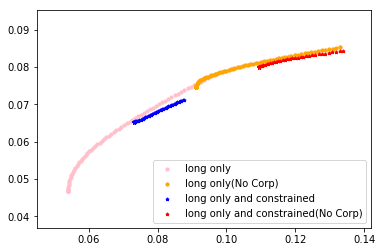

In [6]:
fig= plt.figure()

frontier_uncons_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_uncons.values()]
frontier_uncons_pair.sort(key= lambda x: x[0])
plt.scatter(x= [x[1] for x in frontier_uncons_pair], y= [x[0] for x in frontier_uncons_pair], 
            marker='o', c= 'pink', s=10, label= 'long only')

frontier_uncons_NoCorp_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_uncons_NoCorp.values()]
frontier_uncons_NoCorp_pair.sort(key= lambda x : x[0])
plt.scatter( x= [x[1] for x in frontier_uncons_NoCorp_pair], y = [x[0] for x in frontier_uncons_NoCorp_pair], 
           marker= 'o', c= 'orange', s=10, label= 'long only(No Corp)')


frontier_cons_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_cons.values()]
frontier_cons_pair.sort(key= lambda x : x[0])
plt.scatter(x= [x[1] for x in frontier_cons_pair], y= [x[0] for x in frontier_cons_pair], 
            marker= '*', c= 'blue' , s=10, label= 'long only and constrained')

frontier_cons_NoCorp_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_cons_NoCorp.values()]
frontier_cons_NoCorp_pair.sort(key= lambda x: x[0])
plt.scatter(x= [x[1] for x in frontier_cons_NoCorp_pair], y= [x[0] for x in frontier_cons_NoCorp_pair], 
           marker= '*', c= 'red', s=10, label= 'long only and constrained(No Corp)')
plt.legend()

## Peer Implied Return 


In [7]:
risk_free= 179/10000
gamma= 3.5

UniverseProperty['impliedExpectedReturn_peer_arith']= portfolios['Peer'].implied_ExpectedReturn(gamma= gamma, risk_free= risk_free)
UniverseProperty['impliedExpectedReturn_peer_geo']= UniverseProperty['impliedExpectedReturn_peer_arith']- .5* np.diag(UniverseProperty['LW_cov'])

UniverseProperty['impliedExpectedReturn_peer_geo']

array([ 0.03096314,  0.05941507,  0.01987301,  0.06643129,  0.07014947,
        0.07036907,  0.0680927 ])

In [8]:
np.array(UniverseProperty['impliedExpectedReturn_peer_arith'] )

array([ 0.0359304 ,  0.06939446,  0.02185507,  0.07806678,  0.0895547 ,
        0.08693194,  0.10000493])

## Combined Return (BL) and Frontier 


In [9]:
from blacklitterman import naive_BlackLitterman

In [10]:
#Apply BL to arithmatic expected return 

prior_ExpectedReturn= UniverseProperty['impliedExpectedReturn_peer_arith']
prior_cov= UniverseProperty['LW_cov_active']
tau= 0.05
prior_risk= UniverseProperty['LW_cov']* tau

views_weight= np.identity(UniverseProperty['asset_count'])
views_expectedReturn= UniverseProperty['CMA_active_arith']
views_risk = UniverseProperty['LW_cov_active']* 2*tau


arithBL= naive_BlackLitterman( prior_ExpectedReturn= prior_ExpectedReturn, prior_uncertainty= prior_risk, prior_cov= prior_cov, 
                         views_weight= views_weight, views_return= views_expectedReturn, views_uncertainty= views_risk)

UniverseProperty['arithBL_peer_CMAactive']= arithBL
# Note: the prior, view and post are arithmatic 
# To convert the aithmatic post expected return to geometric, deduct half post return variance. 


In [11]:
arithBL.post_ExpectedReturn- .5* np.diag( arithBL.post_cov) # post geometric expected return 

array([ 0.04380985,  0.06861074,  0.02357064,  0.07104906,  0.07605534,
        0.07312406,  0.07412406])

In [12]:
arithBL.arith2geo()

array([ 0.04380985,  0.06861074,  0.02357064,  0.07104906,  0.07605534,
        0.07312406,  0.07412406])

#### Frontier based on BL post Expected Return

In [13]:
frontier_BLuncons={}

for target_ret in np.linspace(0.045, 0.1, 100 ): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn)- target_ret,
                'jac': lambda w: UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    
    # unconstrained opt
    MV_opt_5= minimize( frontier_obj, 
                    x0= portfolios['EqualWeights'].weight, 
                    args= UniverseProperty['arithBL_peer_CMAactive'].post_cov, 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter': 1000},
                    constraints= cons, 
                    bounds= [[0, None]]* UniverseProperty['asset_count'],
                    tol= 1e-10)  # long only constrain
    
    frontier_BLuncons[target_ret]= Portfolio( asset_ret= UniverseProperty['arithBL_peer_CMAactive'].arith2geo(),
                                         asset_cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov,
                                         weight= MV_opt_5.x)
    




C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]


Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0018061111084892532
            Iterations: 27
            Function evaluations: 28
            Gradient evaluations: 27
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0018438935502451395
            Iterations: 27
            Function evaluations: 27
            Gradient evaluations: 27
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0018837359702019404
            Iterations: 26
            Function evaluations: 27
            Gradient evaluations: 26
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0019256384121274677
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0019696008111688397
            Iterations: 23
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005631622160882155
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00576191882319456
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005894219613636917
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.006028524532956614
            Iterations: 30
            Function evaluations: 30
            Gradient evaluations: 30
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.006164833577161976
            Iterations: 30
          

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.016918501586634785
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.017377530470799502
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.017850753491138804
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.018338171181526846
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.018839783525227624
            Iterations: 10
         

In [14]:
frontier_BLuncons_NoCorp={}


for target_ret in np.linspace(0.07, 0.1, 100): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn)- target_ret,
                'jac': lambda w: UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    initial_guess= np.ones(UniverseProperty['asset_count'])* 1/UniverseProperty['asset_count']
    initial_guess[2]=0
    # unconstrained opt
    MV_opt_6= minimize( frontier_obj, 
                    x0= initial_guess, 
                    args= UniverseProperty['arithBL_peer_CMAactive'].post_cov, 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter':1000},
                    constraints= cons, 
                    bounds= [[0, None], [0, None], [0, 1e-15]]+ [[0, None]]* ( UniverseProperty['asset_count']- 3),
                    tol= 1e-8)  # long only constrain
    
    frontier_BLuncons_NoCorp[target_ret]= Portfolio( asset_ret= UniverseProperty['arithBL_peer_CMAactive'].arith2geo(),
                                         asset_cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov,
                                         weight= MV_opt_6.x)
    




Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0055505959473478965
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005612169271008836
            Iterations: 17
            Function evaluations: 17
            Gradient evaluations: 17
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005675397476558232
            Iterations: 13
            Function evaluations: 13
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005739679536866314
            Iterations: 13
            Function evaluations: 13
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005805445264733835
            Iterations: 13
        

C:\Anaconda3\lib\site-packages\scipy\optimize\slsqp.py:341: RuntimeWarning: invalid value encountered in greater
  bnderr = bnds[:, 0] > bnds[:, 1]



            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0071259222347549965
            Iterations: 13
            Function evaluations: 13
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007215645917923672
            Iterations: 9
            Function evaluations: 9
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007306399434298791
            Iterations: 9
            Function evaluations: 9
            Gradient evaluations: 9
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007398264503098989
            Iterations: 13
            Function evaluations: 13
            Gradient evaluations: 13
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00749167151914837
    

            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.011586327447803416
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.011726906158378613
            Iterations: 15
            Function evaluations: 15
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.011871122361014692
            Iterations: 15
            Function evaluations: 15
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.01201889771411862
            Iterations: 15
            Function evaluations: 15
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit m

In [15]:
frontier_BLcons= {}

for target_ret in np.linspace(0.06, 0.08, 100 ): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn)- target_ret,
                'jac': lambda w: UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    # constrained opt 
    MV_opt_7= minimize( frontier_obj, 
                    x0= portfolios['EqualWeights'].weight, 
                    args= UniverseProperty['arithBL_peer_CMAactive'].post_cov, 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter':1000},
                    constraints= cons, 
                    bounds= [[0,0.3]]* UniverseProperty['asset_count'],
                    tol= 1e-12)  # long only+ concentration constrain
    
    frontier_BLcons[target_ret]=   Portfolio( asset_ret= UniverseProperty['arithBL_peer_CMAactive'].arith2geo(), 
                                        asset_cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov,
                                        weight= MV_opt_7.x)
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0035367698829103776
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003570071900208189
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003603638934318933
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003637470985129017
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.003671568052474299
            Iterations: 21
        

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005032409979752123
            Iterations: 31
            Function evaluations: 31
            Gradient evaluations: 31
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00507608432825434
            Iterations: 31
            Function evaluations: 31
            Gradient evaluations: 31
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00512002503167121
            Iterations: 31
            Function evaluations: 31
            Gradient evaluations: 31
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.005164233620491127
            Iterations: 29
            Function evaluations: 30
            Gradient evaluations: 29
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0052087191230193435
            Iterations: 29
          

            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007954306972016548
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.008021735634038504
            Iterations: 22
            Function evaluations: 22
            Gradient evaluations: 22
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.008089753074734685
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0081583592937476
            Iterations: 29
            Function evaluations: 29
            Gradient evaluations: 29
Optimization terminated successfully.    (Exit mode 0)
            Current f

In [16]:
frontier_BLcons_NoCorp= {}

for target_ret in np.linspace(0.07, 0.085, 100 ): 
    frontier_cons1= {'type': 'ineq', 
                'fun': lambda w: np.dot(w, UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn)- target_ret,
                'jac': lambda w: UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn} 

    cons= (frontier_cons0 # fully invested 
          , frontier_cons1 # return requirement 
          )
    
    # constrained opt 
    initial_guess= np.ones(UniverseProperty['asset_count'])* 1/UniverseProperty['asset_count']
    initial_guess[2]=0
    MV_opt_8= minimize( frontier_obj, 
                    x0= initial_guess, 
                    args= UniverseProperty['arithBL_peer_CMAactive'].post_cov, 
                    jac= frontier_obj_der ,
                    method= 'SLSQP',
                    options= {'disp': True, 'maxiter': 1000},
                    constraints= cons, 
                    bounds= [[0,0.3], [0, 0.3], [0, 1e-15]]+ [[0, 0.3]]* ( UniverseProperty['asset_count']-3) ,
                    tol= 1e-12)  # long only+ concentration constrain
    
    frontier_BLcons_NoCorp[target_ret]=   Portfolio( asset_ret= UniverseProperty['arithBL_peer_CMAactive'].arith2geo(), 
                                        asset_cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov,
                                        weight= MV_opt_8.x)

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0061986921585903895
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0061986921585903895
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0061986921585903895
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0061986921585903895
            Iterations: 16
            Function evaluations: 16
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.0061986921585903895
            Iterations: 16
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007176088920905703
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007221195816566773
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00726663390015848
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00731240317168081
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.007358503631133775
            Iterations: 21
           

Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009180668108284388
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.00923869133324003
            Iterations: 21
            Function evaluations: 21
            Gradient evaluations: 21
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009297045746126317
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009355731346943213
            Iterations: 20
            Function evaluations: 20
            Gradient evaluations: 20
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 0.009414748135690747
            Iterations: 20
          

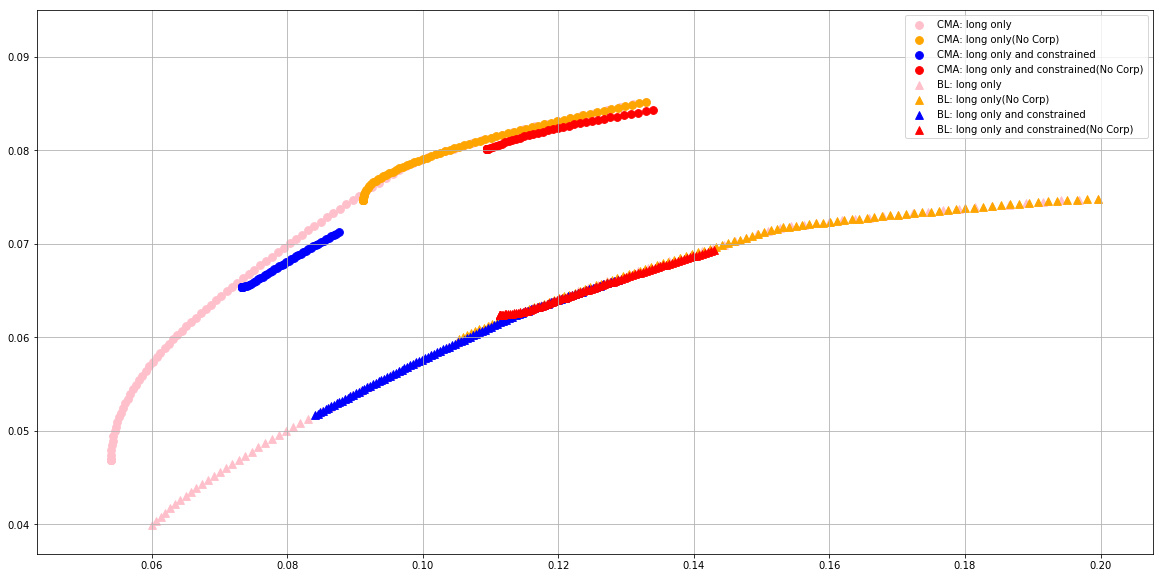

In [17]:
fig= plt.figure(figsize=(20, 10))

plt.scatter(x= [x[1] for x in frontier_uncons_pair], y= [x[0] for x in frontier_uncons_pair], 
            marker='o', c= 'pink', s=60, label= 'CMA: long only')
plt.scatter( x= [x[1] for x in frontier_uncons_NoCorp_pair], y = [x[0] for x in frontier_uncons_NoCorp_pair], 
           marker= 'o', c= 'orange', s=60, label= 'CMA: long only(No Corp)')
plt.scatter(x= [x[1] for x in frontier_cons_pair], y= [x[0] for x in frontier_cons_pair], 
            marker= 'o', c= 'blue' , s=60, label= 'CMA: long only and constrained')
plt.scatter(x= [x[1] for x in frontier_cons_NoCorp_pair], y= [x[0] for x in frontier_cons_NoCorp_pair], 
           marker= 'o', c= 'red', s=60, label= 'CMA: long only and constrained(No Corp)')


frontier_BLuncons_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_BLuncons.values()]
frontier_uncons_pair.sort(key= lambda x: x[0])
plt.scatter(x= [x[1] for x in frontier_BLuncons_pair], y= [x[0] for x in frontier_BLuncons_pair], 
            marker='^', c= 'pink', s=60, label= 'BL: long only')

frontier_BLuncons_NoCorp_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_BLuncons_NoCorp.values()]
frontier_BLuncons_NoCorp_pair.sort(key= lambda x : x[0])
plt.scatter( x= [x[1] for x in frontier_BLuncons_NoCorp_pair], y = [x[0] for x in frontier_BLuncons_NoCorp_pair], 
           marker= '^', c= 'orange', s=60, label= 'BL: long only(No Corp)')


frontier_BLcons_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_BLcons.values()]
frontier_BLcons_pair.sort(key= lambda x : x[0])
plt.scatter(x= [x[1] for x in frontier_BLcons_pair], y= [x[0] for x in frontier_BLcons_pair], 
            marker= '^', c= 'blue' , s=60, label= 'BL: long only and constrained')

frontier_BLcons_NoCorp_pair= [[x.expected_return, x.volatility, x.weight] for x in frontier_BLcons_NoCorp.values()]
frontier_BLcons_NoCorp_pair.sort(key= lambda x: x[0])
plt.scatter(x= [x[1] for x in frontier_BLcons_NoCorp_pair], y= [x[0] for x in frontier_BLcons_NoCorp_pair], 
           marker= '^', c= 'red', s=60, label= 'BL: long only and constrained(No Corp)')
plt.legend()
plt.grid()

Note: 
1. CMA results are represented by nodes while the BL results are triangles. BL result shifted down relative to CMA since BL post return is lower than CMA active. 

2. Applying BL slacks the concentration constrain (at 30% level)

3. Applying BL makes US Corp less different from other assets, hence insensitive to the NoCorp Constrain. (Kicking out US Corp leads to smooth extension of the frontier and insignificant jump compared to the CMA cases.)

## Active Management Optimization


Treat Peer as bechmark, max the benefit from deviation with limited tracking error budget. 

In [18]:

w_b= portfolios['Peer'].weight
expected_return= UniverseProperty['arithBL_peer_CMAactive'].post_ExpectedReturn
cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov
benchmark_portfolio= Portfolio( asset_ret= UniverseProperty['arithBL_peer_CMAactive'].arith2geo(), 
                               asset_cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov, 
                               weight= portfolios['Peer'].weight)


frontier_activeM= {} # key tracking error, value the optmized portfolio 



def activeMang_obj(w):
    return  -1*np.dot((w- w_b), expected_return )

def activeMang_obj_der( w): 
    return -1* expected_return

activeMang_cons0= {'type': 'eq',
          'fun': lambda w: np.array( [np.sum(w)-1] ) ,
          'jac': lambda w: np.array( [1]*w.size)}

for trackingError in np.linspace(0, .1, 100): 
    activeMang_cons1= {'type': 'ineq',
                      'fun': lambda w: trackingError**2 - np.dot( np.dot( w- w_b, cov), w-w_b),
                      'jac': lambda w: -2* np.dot(cov, w- w_b)}
    
    activeMang_cons= (activeMang_cons0, 
                     activeMang_cons1)
    MV_opt_9= minimize( activeMang_obj, 
                      x0= w_b,
                      jac= activeMang_obj_der,
                      method= 'SLSQP', 
                      options= {'disp': True, 'maxiter': 1000},
                      constraints= activeMang_cons,
                      bounds= [[0, 0.3]]* UniverseProperty['asset_count'],
                      tol= 1e-12)
    frontier_activeM[trackingError]= Portfolio( asset_ret= UniverseProperty['arithBL_peer_CMAactive'].arith2geo(),
                                               asset_cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov, 
                                               weight= MV_opt_9.x, benchmark_portfolio= benchmark_portfolio)
    
    

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -4.8332856665799196e-12
            Iterations: 112
            Function evaluations: 221
            Gradient evaluations: 112
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.0003963962185422194
            Iterations: 19
            Function evaluations: 28
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.0007927924368546288
            Iterations: 16
            Function evaluations: 20
            Gradient evaluations: 16
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.001189188654623979
            Iterations: 15
            Function evaluations: 17
            Gradient evaluations: 15
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.00158558487283354
            Iterations: 1

            Current function value: -0.013714627038043097
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.013899831751823251
            Iterations: 18
            Function evaluations: 18
            Gradient evaluations: 18
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.01408395734082268
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.01426708199889836
            Iterations: 19
            Function evaluations: 19
            Gradient evaluations: 19
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.014449276174566709
            Iterations: 21
            Function evaluations: 21
            Gradient eva

Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.019174776313502784
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.019174776313502784
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.019174776313502784
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.019174776313502784
            Iterations: 10
            Function evaluations: 10
            Gradient evaluations: 10
Optimization terminated successfully.    (Exit mode 0)
            Current function value: -0.019174776313502784
            Iterations: 10
    

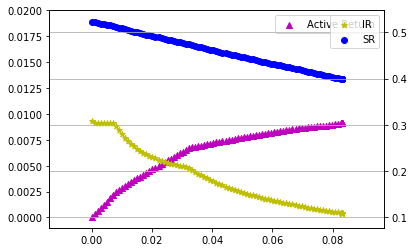

In [19]:
frontier_activeM_pair= [[x.active_expectedReturn, 
                         x.tracking_error, 
                         x.active_expectedReturn/ x.tracking_error,
                         x.SharpeRatio(risk_free= 0) ,
                         x.weight] 
                        for x in frontier_activeM.values()]
frontier_activeM_pair.sort(key= lambda x: x[2], reverse= True)
max_IR= frontier_activeM_pair[0]
frontier_activeM_pair.sort(key= lambda x:x[3], reverse= True)
max_SR= frontier_activeM_pair[0]
frontier_activeM_pair.sort( key= lambda x: x[0])
fig, ax1= plt.subplots()
ax2= ax1.twinx()
ax1.scatter( x= [ x[1] for x in frontier_activeM_pair ], y= [ x[0] for x in frontier_activeM_pair], marker='^', c= 'm', label= 'Active Return') 
ax2.scatter(x= [ x[1] for x in frontier_activeM_pair], y= [x[2] for x in frontier_activeM_pair], marker= '*', c= 'y', label= 'IR')
ax2.scatter( x= [x[1] for x in frontier_activeM_pair], y= [x[3] for x in frontier_activeM_pair], marker= 'o', c= 'b', label= 'SR')
# plt.xlim(- 0.01, 0.035 )
ax1.set_ylim(-1e-3, 0.02)
#plt.ylim( -1e-3, 0.02)
ax1.legend()
ax2.legend()

plt.grid()

In [20]:
benchmark_portfolio.volatility

0.12428132380236374

In [21]:
benchmark_portfolio.expected_return

0.064955163370140942

In [22]:
frontier_activeM_pair.sort(key= lambda x: x[0])
frontier_activeM_pair

[[3.808978230811031e-12,
  1.2378057675891136e-11,
  0.30772018765349712,
  0.52264621409734613,
  array([ 0.13861386,  0.28712871,  0.04950495,  0.23762376,  0.02970297,
          0.20792079,  0.04950495])],
 [0.00030761961872589763,
  0.0010101010109649314,
  0.30454342227816811,
  0.5213895318629771,
  array([ 0.13928728,  0.2889524 ,  0.04271249,  0.23910143,  0.0301378 ,
          0.2095107 ,  0.05029791])],
 [0.00061523970523041168,
  0.0020202020213507914,
  0.30454365391587757,
  0.5201430872775461,
  array([ 0.1399606 ,  0.29077613,  0.03592007,  0.24057911,  0.03057269,
          0.21110058,  0.05109083])],
 [0.00092285931678028413,
  0.0030303030303061424,
  0.30454357453718101,
  0.5189068808824987,
  array([ 0.14063408,  0.29259973,  0.02912758,  0.24205676,  0.03100753,
          0.21269054,  0.05188377])],
 [0.0012304791026896515,
  0.0040404040404122777,
  0.30454357791506786,
  0.51768089482128898,
  array([ 0.14130749,  0.2944234 ,  0.02233512,  0.24353443,  0.0314423

## Portfolio Construction 


In [23]:
# mean variance opt based over post BL and target peer return 

benchmark_portfolio= Portfolio( asset_ret= UniverseProperty['arithBL_peer_CMAactive'].arith2geo(), 
                               asset_cov= UniverseProperty['arithBL_peer_CMAactive'].post_cov, 
                               weight= portfolios['Peer'].weight)

base_portfolio_w= sorted( [x for x in frontier_BLcons_pair if x[0]>= benchmark_portfolio.expected_return], key= lambda x: x[0]) [0]
base_portfolio= Portfolio(asset_ret= benchmark_portfolio.asset_return,
                         asset_cov= benchmark_portfolio.asset_cov,
                         weight= base_portfolio_w[2])

In [24]:
benchmark_portfolio.expected_return

0.064955163370140942

In [25]:
benchmark_portfolio.volatility

0.12428132380236374

In [26]:
benchmark_portfolio.weight

array([ 0.13861386,  0.28712871,  0.04950495,  0.23762376,  0.02970297,
        0.20792079,  0.04950495])

In [27]:
base_portfolio.weight

array([ 0.22818002,  0.3       ,  0.        ,  0.16908807,  0.06675601,
        0.1549494 ,  0.0810265 ])

The base_portfolio achieves similar return as bechmark with smaller vol. 

In [28]:
# For display purpose 


writter= pd.ExcelWriter('output_wz3.xlsx')
tmp_df1= pd.DataFrame(   [[x[0], x[1]]+ x[2].tolist()  for x in frontier_uncons_pair], 
                      columns= ['ExpectedRet', 'vol']+ UniverseProperty['asset_name']  )
tmp_df2= pd.DataFrame(  [[x[0], x[1]]+ x[2].tolist()  for x in frontier_uncons_NoCorp_pair], 
                     columns=  ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])
tmp_df3= pd.DataFrame(  [[x[0], x[1]]+ x[2].tolist()  for x in frontier_cons_pair], 
                     columns=  ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])
tmp_df4= pd.DataFrame(  [[x[0], x[1]]+ x[2].tolist()  for x in frontier_cons_NoCorp_pair], 
                     columns=  ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])
tmp_df5= pd.DataFrame( [[x[0], x[1]]+ x[2].tolist() for x in frontier_BLuncons_pair], 
                     columns= ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])
tmp_df6= pd.DataFrame( [[x[0], x[1]]+ x[2].tolist() for x in frontier_BLuncons_NoCorp_pair],
                     columns= ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])
tmp_df7= pd.DataFrame( [[x[0], x[1]]+ x[2].tolist() for x in frontier_BLcons_pair], 
                     columns= ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])
tmp_df8= pd.DataFrame( [[x[0], x[1]]+ x[2].tolist() for x in frontier_BLcons_NoCorp_pair],
                     columns= ['ExpectedRet', 'vol']+ UniverseProperty['asset_name'])

frontier_activeM_pair.sort(key= lambda x: x[0])
tmp_df9= pd.DataFrame(  [[x[0], x[1], x[2], x[3]]+ x[4].tolist() for x in frontier_activeM_pair], 
                     columns= ['active_ExpReturn', 'trackingError', 'IR', 'SR']+ UniverseProperty['asset_name'])

tmp_df1.to_excel( writter, 'UNCONS')
tmp_df2.to_excel( writter, 'UNCONS_NoCorp')
tmp_df3.to_excel( writter, 'CONS')
tmp_df4.to_excel( writter, 'CONS_NoCorp')
tmp_df5.to_excel( writter, 'BL_UNCONS')
tmp_df6.to_excel( writter, 'BL_UNCONS_NoCorp')
tmp_df7.to_excel( writter, 'BL_CONS')
tmp_df8.to_excel( writter,  'BL_CONS_NoCorp')
tmp_df9.to_excel( writter, 'BL_activeOpt')
writter.save()
